# **Project 2: RNNs**

# Table of Contents
* [Dataset](#dataset)
* [Simple RNN](#simple_rnn)
* [Manual RNN](#man_rnn)
* [LSTM](#lstm)
* [GRU](#gru)
* [Stacked RNN](#stacked)
* [Pre-trained RNN](#pre-trained)
* [Model Training](#training)
* [MLflow and Plots](#plots)

I will be using the Electricity Transformer Dataset (ETDataset). The dataset ranges from 2016/07 to 2018/07. It has the data of 2 Electricity Transformers at 2 stations, including load, oil temperature. Each dataset contains 2 years * 365 days * 24 hours * 4 times = 70,080 data points.

In [1]:
# Import
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
import datetime
import os
import time
from datetime import datetime

import torch
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
 
from datasets import load_dataset

from IPython.display import display, HTML, IFrame

%matplotlib inline

## Dataset <a class="anchor" id="dataset"></a>

In [2]:
ETTm1 = pd.read_csv("Oil_dataset\ETTm1.csv")
ETTm2 = pd.read_csv("Oil_dataset\ETTm2.csv")
ETTm1

<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:2: SyntaxWarning: invalid escape sequence '\E'
<>:1: SyntaxWarning: invalid escape sequence '\E'
<>:2: SyntaxWarning: invalid escape sequence '\E'
C:\Users\rvaal\AppData\Local\Temp\ipykernel_11488\1694139503.py:1: SyntaxWarning: invalid escape sequence '\E'
  ETTm1 = pd.read_csv("Oil_dataset\ETTm1.csv")
C:\Users\rvaal\AppData\Local\Temp\ipykernel_11488\1694139503.py:2: SyntaxWarning: invalid escape sequence '\E'
  ETTm2 = pd.read_csv("Oil_dataset\ETTm2.csv")


,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 00:15:00,5.760,2.076,1.492,0.426,4.264,1.401,30.459999
2,2016-07-01 00:30:00,5.760,1.942,1.492,0.391,4.234,1.310,30.038000
3,2016-07-01 00:45:00,5.760,1.942,1.492,0.426,4.234,1.310,27.013000
4,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,9.310,3.550,5.437,1.670,3.868,1.462,9.567000
69676,2018-06-26 19:00:00,10.114,3.550,6.183,1.564,3.716,1.462,9.567000
69677,2018-06-26 19:15:00,10.784,3.349,7.000,1.635,3.746,1.432,9.426000
69678,2018-06-26 19:30:00,11.655,3.617,7.533,1.706,4.173,1.523,9.426000


In [3]:
times_date = []
for i in range(len(ETTm1["date"])):
    datetime_str = ETTm1["date"][i]
    datetime_new = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    times_date.append(datetime_new) 

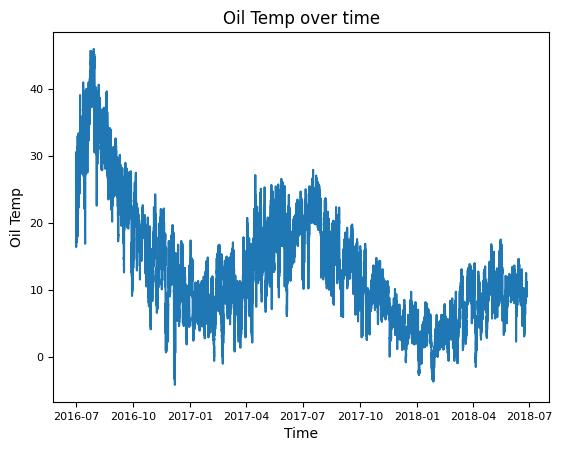

In [4]:
fig1,ax1 = plt.subplots()
ax1.plot(times_date, ETTm1["OT"])
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_xlabel('Time')
ax1.set_ylabel('Oil Temp')
ax1.set_title('Oil Temp over time')
plt.show()

The dataset shows the changes in transformer load every 15 min. The target is the oil temperature.

**From the dataset authors**: *"The electric power distribution problem is the distribution of electricity to different areas depends on its sequential usage. But predicting the following demand of a specific area is difficult, as it varies with weekdays, holidays, seasons, weather, temperatures, etc. However, no existing method can perform a long-term prediction based on super long-term real-world data with high precision. Any false prophecy may damage the electrical transformer. So currently, **without an efficient method to predict future electric usage, managers have to make decisions based on the empirical number, which is much higher than the real-world demands. It causes unnecessary waste of electric and equipment depreciation. On the other hand, the oil temperatures can reflect the conditon of electricity Transformer. One of the most efficient strategies is to predict how the electrical transformers' oil temperature is safe and avoid unnecessary waste.** As a result, to address this problem, our team and Beijing Guowang Fuda Science & Technology Development Company built a real-world platform and collected 2-year data. We work on it to predict the electrical transformers' oil temperature and investigate the extreme load capacity"*

In [5]:
class OilTempDataset(Dataset):
    def __init__(self, dataframe, sequence_length=10, target_column='Methane conc (ppm)'):
        """
        Initializes the dataset by scaling the features, creating sequences, and separating targets.
        
        Args:
            dataframe (pd.DataFrame): The dataset containing sensor data and gas concentration.
            sequence_length (int): Number of past time steps to consider for each sequence.
            target_column (str): Column name of the target variable in the dataframe.
        """
        self.sequence_length = sequence_length
        
        # Extract the features and target
        features = dataframe[["HUFL","HULL","MUFL","MULL","LUFL","LULL"]]
        target = dataframe[target_column]
        
        # Scale the features
        self.scaler = MinMaxScaler()
        scaled_features = self.scaler.fit_transform(features)
        
        # Create sequences
        self.data = []
        self.targets = []
        for i in range(len(scaled_features) - sequence_length):
            self.data.append(scaled_features[i:i+sequence_length])
            self.targets.append(target.iloc[i+sequence_length])
        
        # Convert to numpy arrays
        self.data = np.array(self.data)
        self.targets = np.array(self.targets)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # Convert data and target to PyTorch tensors
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y

In [6]:
# Assume df is the loaded DataFrame with columns as described
sequence_length = 10
target_column = 'OT'

# Create the dataset
dataset = OilTempDataset(dataframe=ETTm1, sequence_length=sequence_length, target_column=target_column)

# Create the DataLoader
batch_size = 32
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example of iterating over the dataset
for inputs, targets in data_loader:
    print("Input sequence shape:", inputs.shape)  # Should be (batch_size, sequence_length, num_features)
    print("Target shape:", targets.shape)         # Should be (batch_size,)
    break

Input sequence shape: torch.Size([32, 10, 6])
Target shape: torch.Size([32])


In [7]:
# Define split ratios
train_ratio = 0.8
test_ratio = 1 - train_ratio

# Calculate lengths for each subset
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for training and testing sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verify the split
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")

Training set size: 55736
Testing set size: 13934


## Simple RNN <a id="simple_rnn"></a>

In [8]:
import torch.nn as nn

class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(SimpleRNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # Take the final hidden state
        out = self.fc(hidden[-1])  # Pass through a fully connected layer
        return out

## Manual RNN <a id="man_rnn"></a>

In [9]:
class ManRNN():
    def __init__(self,input_size_hidden_size_num_layers):
        ...

    def forward(self,x):
        ...

## LSTM <a id="lstm"></a>

In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out

## GRU (peab manuaalselt ümber kirjutama) <a id="gru"></a>

In [11]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.gru(x)
        out = self.fc(hidden[-1])
        return out

## Stacked RNN <a id="stacked"></a>

In [12]:
class StackedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StackedRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        _, hidden = self.rnn(x)  # Take the final hidden state
        out = self.fc(hidden[-1])  # Pass through a fully connected layer
        return out

## Pre-trained RNN <a id="pre-trained"></a>

In [13]:
import mlflow
from mlflow.models import infer_signature

In [14]:
# Define the model hyperparameters
params = {
    "input_size": 6,
    "hidden_size": 64,
    "num_layers": 2,
    "num_epochs": 30,
    "learning_rate": 0.002,
}

## Model Training <a id="training"></a>

Here I am using R2, because we want to predict future values of the oil temperature.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [26]:
# Train the model

def train_model(model, train_loader, test_loader, num_epochs=10, learning_rate=0.001):
    criterion = nn.MSELoss()  # Mean squared error for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    r2 = 0
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        model = model.to(device) # Put model on cuda

        for i, data in enumerate(train_loader, 0):
            
            inputs, targets = data
            inputs, targets = inputs.to(device),targets.to(device) # Put inputs on cuda
                                                          
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')

    return train_losses,r2

In [17]:
# Plot function
def training_loss_plot(train_loss,label):
    fig,ax = plt.subplots()
    ax.plot(train_loss, label=label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Training Loss')
    ax.legend()
    ax.set_title(f'{label} Training Loss Comparison')
    plt.show()
    return fig

## MLflow and Plots <a id="plots"></a>


In [18]:
simple_rnn = SimpleRNNModel(params["input_size"],params["hidden_size"])
lstm_model = LSTMModel(params["input_size"],params["hidden_size"],params["num_layers"])
gru_model = GRUModel(params["input_size"],params["hidden_size"],params["num_layers"])
stacked_rnn= StackedRNN(params["input_size"],params["hidden_size"],params["num_layers"])    

2024/12/08 17:09:22 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


Simple RNN:
Epoch [1/30], Loss: 75.7288
Epoch [2/30], Loss: 70.7142
Epoch [3/30], Loss: 69.6430
Epoch [4/30], Loss: 69.2107
Epoch [5/30], Loss: 66.6038
Epoch [6/30], Loss: 59.3848
Epoch [7/30], Loss: 57.7756
Epoch [8/30], Loss: 56.0694
Epoch [9/30], Loss: 54.8612
Epoch [10/30], Loss: 53.7904
Epoch [11/30], Loss: 52.2483
Epoch [12/30], Loss: 50.5879
Epoch [13/30], Loss: 51.4627
Epoch [14/30], Loss: 51.0550
Epoch [15/30], Loss: 49.0620
Epoch [16/30], Loss: 50.1520
Epoch [17/30], Loss: 47.7513
Epoch [18/30], Loss: 46.6922
Epoch [19/30], Loss: 45.8028
Epoch [20/30], Loss: 45.0900
Epoch [21/30], Loss: 45.7091
Epoch [22/30], Loss: 48.3610
Epoch [23/30], Loss: 46.1907
Epoch [24/30], Loss: 50.7896
Epoch [25/30], Loss: 46.4259
Epoch [26/30], Loss: 46.0397
Epoch [27/30], Loss: 44.8718
Epoch [28/30], Loss: 44.4585
Epoch [29/30], Loss: 44.7328
Epoch [30/30], Loss: 44.5646
LSTM:
Epoch [1/30], Loss: 75.8835
Epoch [2/30], Loss: 73.4954
Epoch [3/30], Loss: 73.4871
Epoch [4/30], Loss: 72.2476
Epoch [5/

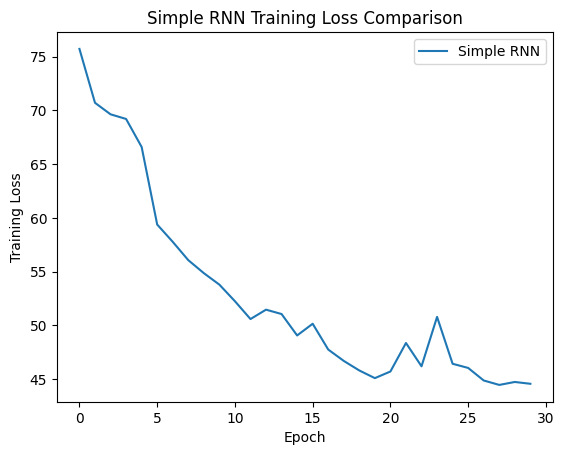

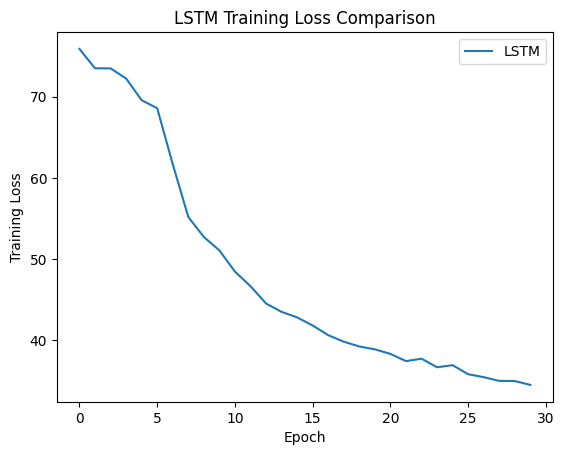

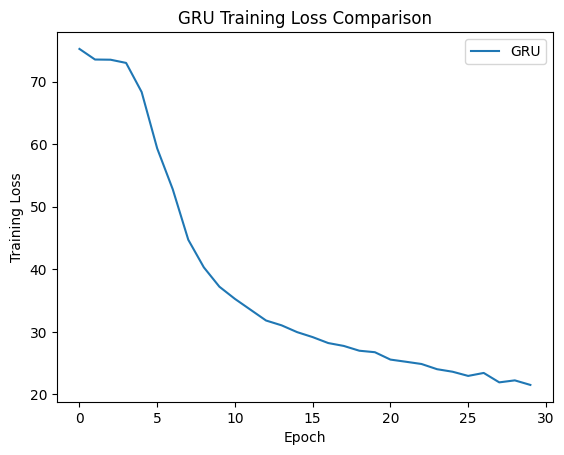

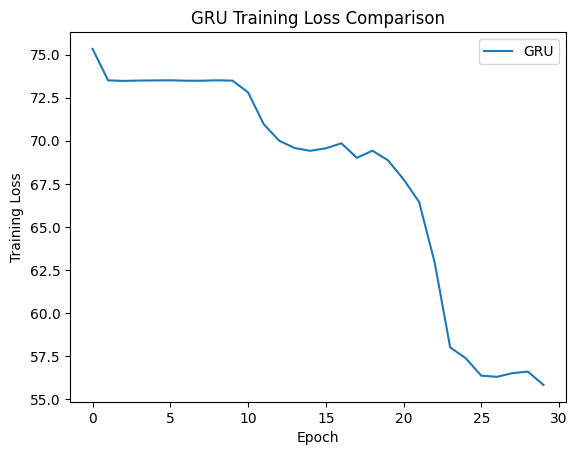

🏃 View run rare-dog-135 at: http://127.0.0.1:8080/#/experiments/279958537299527402/runs/27c79fd4229e495c82cc6cd6614529ff
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/279958537299527402


In [19]:
# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

# Create a new MLflow Experiment
mlflow.set_experiment("RNN")


mlflow.autolog()

# Start an MLflow run
with mlflow.start_run():

    print("Simple RNN:")
    train_loss_rnn,r2_rnn = train_model(simple_rnn, train_loader, test_loader, params["num_epochs"], params["learning_rate"])
    print("LSTM:")
    train_loss_lstm,r2_lstm = train_model(lstm_model, train_loader,test_loader, params["num_epochs"], params["learning_rate"])
    print("GRU:")
    train_loss_gru,r2_gru = train_model(gru_model, train_loader, test_loader, params["num_epochs"], params["learning_rate"])
    print("Stacked RNN:")
    train_loss_stacked,r2_stacked = train_model(stacked_rnn, train_loader, test_loader, params["num_epochs"], params["learning_rate"])

    # Plot training losses
    fig1 = training_loss_plot(train_loss_rnn,"Simple RNN")
    fig2 = training_loss_plot(train_loss_lstm,"LSTM")
    fig3 = training_loss_plot(train_loss_gru,"GRU")
    fig4 = training_loss_plot(train_loss_stacked,"GRU")

    # Log the hyperparameters
    mlflow.log_params(params)

    # Log the loss metric
    mlflow.log_metric("RNN accuracy", train_loss_rnn[-1])
    mlflow.log_metric("LSTM accuracy", train_loss_lstm[-1])
    mlflow.log_metric("GRU accuracy", train_loss_gru[-1])
    mlflow.log_metric("Stacked RNN accuracy", train_loss_stacked[-1])

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "RNN for ETT data (RNN,LSTM,GRU)")

    # Log the plots
    mlflow.log_figure(fig1, "training_loss_rnn_comparison.png")
    mlflow.log_figure(fig2, "training_loss_lstm_comparison.png")
    mlflow.log_figure(fig3, "training_loss_gru_comparison.png")
    mlflow.log_figure(fig4, "training_loss_stacked_rnn_comparison.png")

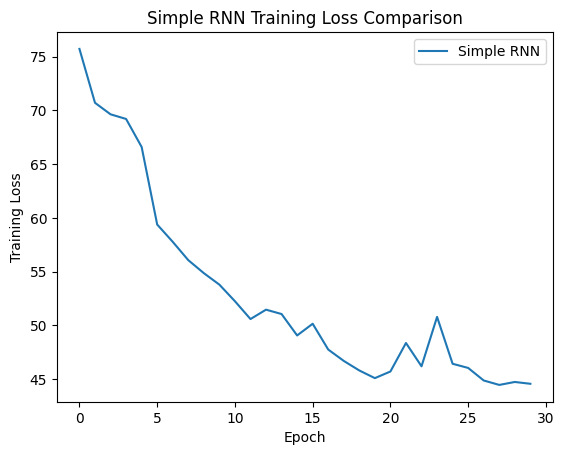

In [20]:
fig1

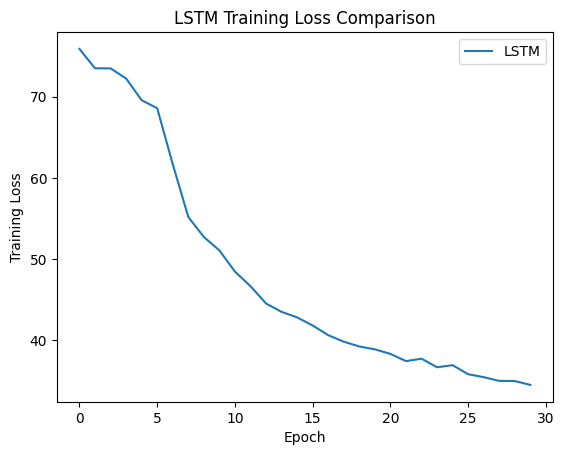

In [21]:
fig2

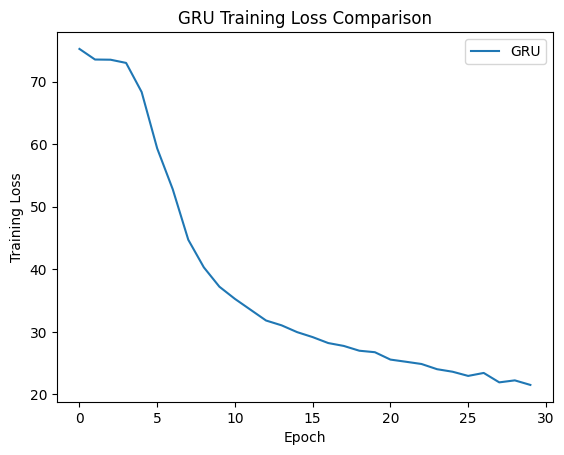

In [22]:
fig3

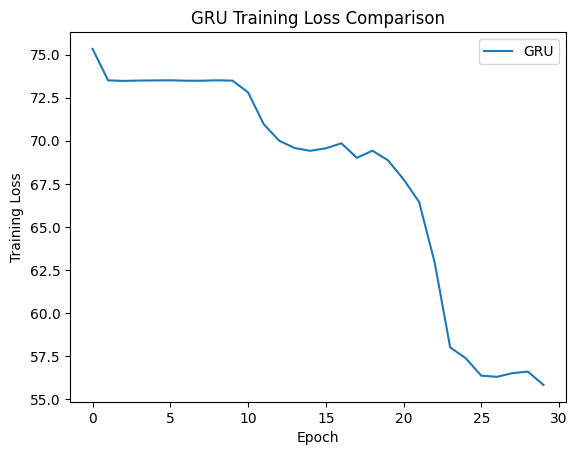

In [23]:
fig4

In [25]:
from IPython.display import display, HTML, IFrame

IFrame(src="http://127.0.0.1:8080/#/experiments/279958537299527402/runs/27c79fd4229e495c82cc6cd6614529ff", width="100%", height=720)